# 2025 Dover Monte Carlo Simulation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import requests
from PIL import Image
from io import BytesIO
from collections import Counter

In [2]:
cup_roster = pd.read_csv("https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/refs/heads/main/Data/Master-Data/2025-cup-series-full-timers.txt")

In [6]:
simulation_data = pd.read_csv("https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/refs/heads/main/Data/Dover-2025/dover-sim-ready-data.csv")
for col in simulation_data.columns:
    if "Unnamed" in col:
        simulation_data = simulation_data.drop(columns=[col])
simulation_data.head()

,Driver,Avg Finish,Wins,Top 5's,DNF,Avg Rating,szn_Avg Finish,szn_Wins,szn_Top 5's,szn_Avg Rating,DNF_Prob,track_Laps Led Per Race,szn_Laps Led Per Race,Std Dev
0,Kyle Larson,8.2,1,8,0,103.8,13.8,3,9,92.2,0.030000,58.625000,42.70,2.5
1,Chase Elliott,9.5,2,10,2,96.1,10.2,1,7,88.7,0.142857,28.142857,6.80,2.5
2,Ty Gibbs,11.5,0,0,0,86.2,17.7,0,3,73.7,0.150000,0.000000,4.85,2.5
3,Brad Keselowski,13.5,1,5,1,90.3,22.4,0,2,66.5,0.038462,15.807692,4.05,3.5
4,Erik Jones,13.8,0,1,1,79.1,19.3,0,2,65.3,0.090909,0.000000,0.05,3.5


In [ ]:
# same exact method as Pocono, but added more param logging for evaluating results:
def simulate_race(df):
    finish_positions = []
    
    for _, row in df.iterrows():
        # calculate a performance bonus to add a weight to drivers who have performed well
        # at track in categories other than avg. finish
        performance_bonus = (
            0.40 * row['Wins'] +                         # wins @ track
            0.20 * row['szn_Wins'] +                     # season wins
            0.10 * row['track_Laps Led Per Race'] +      # laps led per race @ track
            0.10 * row['szn_Laps Led Per Race'] +        # laps led per race over szn
            0.05 * row['Avg Rating'] +                   # average rating on the track
            0.05 * row['szn_Avg Rating'] +               # average rating over whole season
            0.05 * row['Top 5\'s'] +                     # top 5's @ track 
            0.05 * row['szn_Top 5\'s']                   # season top 5's
        )

        # Apply bonus: decrease average finish (but not below 1)
        adjusted_avg_finish = max(1, (row['Avg Finish'] + (0.5 * row['szn_Avg Finish']))/2 - performance_bonus * 0.25)

        # quick check for a DNF
        dnf = np.random.rand() < row['DNF_Prob']
        
        if dnf:
            # DNF finish at the back of the pack
            finish_pos = np.random.randint(len(df) + 1, len(df) + 6)
        else:
            # Finished race: sample finish from a normal distribution centered at the
            # adjusted average finish location we found earlier (help incorporate things like wins)
            # use the std dev calculated from avg finish to control variability
            finish_pos = np.random.normal(loc=adjusted_avg_finish, scale=row['Std Dev'])
            
            # bound finish position between 1 and number of drivers so we get nothing crazy
            finish_pos = max(1, min(len(df), finish_pos))
        
        finish_positions.append((row['Driver'], finish_pos, dnf))
    
    # convert the list to a dataframe to sort and view easier
    results = pd.DataFrame(finish_positions, columns=['Driver', 'Finish_Pos', 'DNF'])
    
    # sort by DNF first (non-DNF comes first), then finish position
    results = results.sort_values(by=['DNF', 'Finish_Pos'], ascending=[True, True]).reset_index(drop=True)
    
    # driver in position 0 is the winner of that simulation
    # winner = results.iloc[0]['Driver'] # old method to just find the winner, instead now pull a whole df each sim for all finishing posns
    return results

def run_simulations(df, num_simulations=10000):
    # init tracking dictionary for what we do later
    results_tracker = {driver: [] for driver in df['Driver']}
    win_counts = {driver: 0 for driver in df['Driver']}

    # do n simulations of race results and then track stats
    for _ in range(num_simulations):
        race_result = simulate_race(df)
        for idx, row in race_result.iterrows():
            driver = row['Driver']
            pos = row['Finish_Pos']
            results_tracker[driver].append(pos)
        winner = race_result.iloc[0]['Driver']
        win_counts[winner] += 1

    # combine everything into final results, including statistics like avg finish and standard deviation of all finishes
    final_data = []
    for driver in df['Driver']:
        finishes = results_tracker[driver]
        avg_finish = np.mean(finishes)
        std_dev = np.std(finishes)
        wins = win_counts[driver]
        win_prob = wins / num_simulations
        final_data.append((driver, wins, win_prob, avg_finish, std_dev))

    # build final dataframe
    win_probs = pd.DataFrame(final_data, columns=['Driver', 'Wins', 'Win_Prob', 'Avg_Finish', 'Finish_StdDev'])
    win_probs = win_probs.sort_values(by='Win_Prob', ascending=False).reset_index(drop=True)
    return win_probs

In [ ]:
# run the simulation n=10000 times
results = run_simulations(simulation_data)
print(results)

                  Driver  Wins  Win_Prob  Avg_Finish  Finish_StdDev
0            Kyle Larson  5207    0.5207    3.710013       6.165271
1          Chase Elliott  1833    0.1833    8.461769      11.514034
2          William Byron   530    0.0530    9.894621       9.458702
3           Denny Hamlin   488    0.0488   10.614789       9.932192
4             Kyle Busch   361    0.0361   13.232259      11.688088
5          Tyler Reddick   238    0.0238    9.243930       5.855206
6       Christopher Bell   197    0.0197   14.463219      10.515055
7            Joey Logano   191    0.0191   10.903962       7.909356
8        Brad Keselowski   131    0.0131   10.841744       6.204103
9         Chris Buescher   115    0.0115   13.280178       7.687855
10              Ty Gibbs    95    0.0095   12.252744      10.333252
11            Erik Jones    89    0.0089   12.218248       8.195847
12           Ryan Blaney    76    0.0076   12.240726       7.665684
13         Ross Chastain    75    0.0075   14.46

In [17]:
results_with_nums = results.merge(cup_roster[['Driver', 'Car No.']], on='Driver', how='left')
top_10 = results_with_nums.sort_values(by='Win_Prob', ascending=False).head(10).reset_index(drop=True)
top_10

,Driver,Wins,Win_Prob,Avg_Finish,Finish_StdDev,Car No.
0,Kyle Larson,5207,0.5207,3.710013,6.165271,5
1,Chase Elliott,1833,0.1833,8.461769,11.514034,9
2,William Byron,530,0.0530,9.894621,9.458702,24
3,Denny Hamlin,488,0.0488,10.614789,9.932192,11
4,Kyle Busch,361,0.0361,13.232259,11.688088,8
5,Tyler Reddick,238,0.0238,9.243930,5.855206,45
6,Christopher Bell,197,0.0197,14.463219,10.515055,20
7,Joey Logano,191,0.0191,10.903962,7.909356,22
8,Brad Keselowski,131,0.0131,10.841744,6.204103,6
9,Chris Buescher,115,0.0115,13.280178,7.687855,17


In [18]:
# really cool function to extract most common color from a png: you'll see it below
def get_main_hex_color(url):
    resp = requests.get(url)
    img = Image.open(BytesIO(resp.content)).convert('RGBA')
    img = img.resize((50, 50))  # resize to reduce TC
    pixels = list(img.getdata())

    # filter out transparent pixels
    opaque_pixels = [pixel[:3] for pixel in pixels if pixel[3] != 0]
    if not opaque_pixels:
        return None

    color_counts = Counter(opaque_pixels).most_common()

    def is_black_or_white(rgb):
        return rgb == (0, 0, 0) or rgb == (255, 255, 255)

    # find most common color that is not black or white
    for color, count in color_counts:
        if not is_black_or_white(color):
            most_common_color = color
            break
    else:
        # fallback if all are black or white
        most_common_color = color_counts[0][0]

    return '#{:02x}{:02x}{:02x}'.format(*most_common_color)

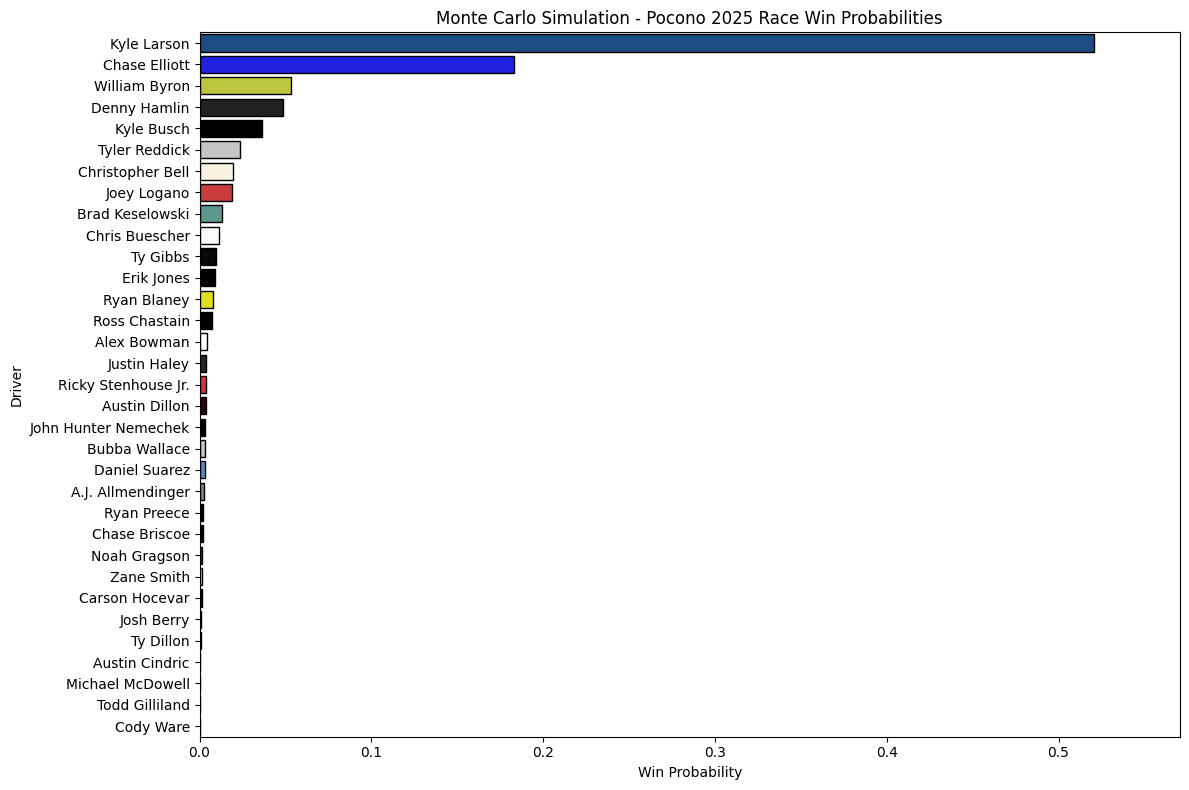

In [19]:
bar_colors = []

for idx, row in results.iterrows():
    car_num = cup_roster.loc[cup_roster['Driver'] == row['Driver'], 'Car No.'].values[0]
    img_url = f"https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/main/Data/Driver-Num-Logos/{car_num}.png"
    col = get_main_hex_color(img_url)
    bar_colors.append(col)

plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=results,
    x='Win_Prob',
    y='Driver',
    hue='Driver',
    palette=bar_colors,
    dodge=False,
    legend=False
) # bunch of extra commands to dodge FutureWarning

for bar in barplot.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)
    
plt.xlabel('Win Probability')
plt.ylabel('Driver')
plt.title('Monte Carlo Simulation - Pocono 2025 Race Win Probabilities')
plt.xlim(0, results['Win_Prob'].max() + 0.05)

plt.tight_layout()
plt.show()

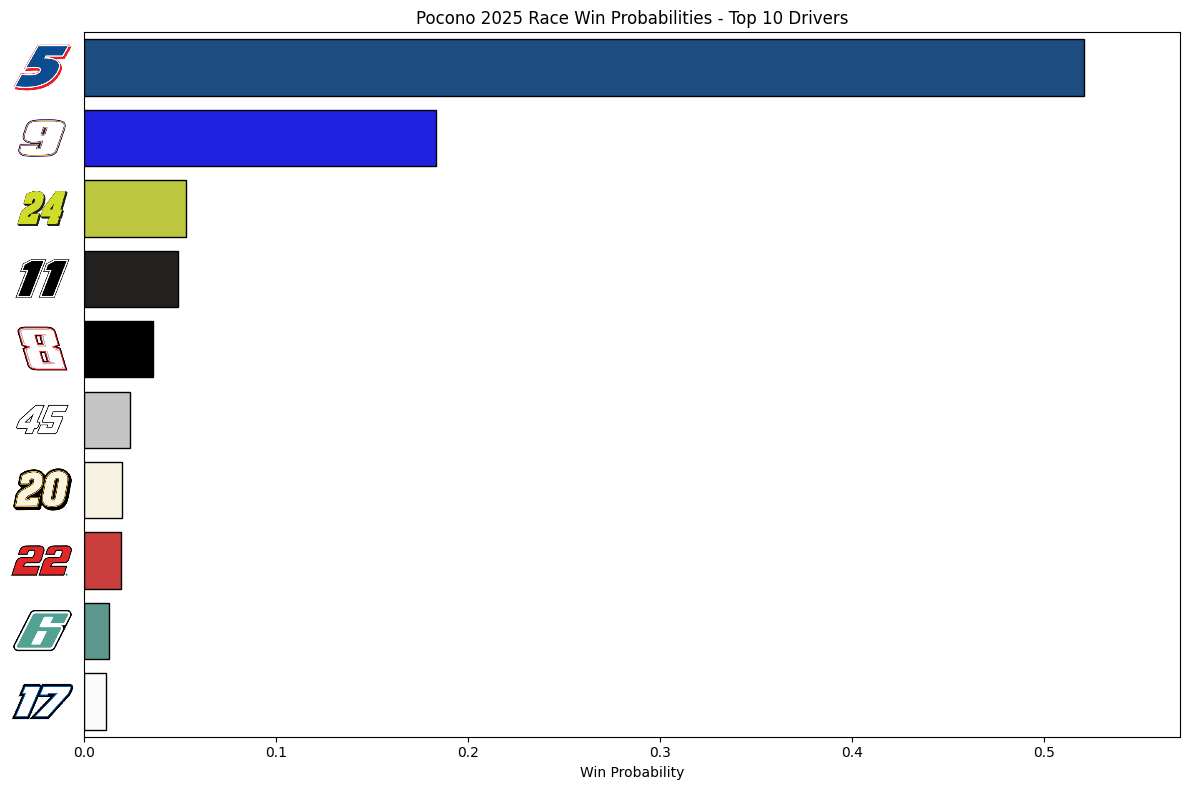

In [20]:
# define colors from driver num logo using function above 
bar_colors = []

for idx, row in top_10.iterrows():
    img_url = f"https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/main/Data/Driver-Num-Logos/{row['Car No.']}.png"
    col = get_main_hex_color(img_url)
    bar_colors.append(col)

plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=top_10,
    x='Win_Prob',
    y='Driver',
    hue='Driver',
    palette=bar_colors,
    dodge=False,
    legend=False
) # bunch of extra commands to dodge FutureWarning

# add black outline
for bar in barplot.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)

plt.yticks([])

plt.xlabel('Win Probability')
plt.ylabel('')
plt.title('Pocono 2025 Race Win Probabilities - Top 10 Drivers')
plt.xlim(0, top_10['Win_Prob'].max() + 0.05)

# Add car number images
for i, car_num in enumerate(top_10['Car No.']):
    #Old logic when images were local; swapped out b/c GitHub storage
    #img_path = f"https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/main/Driver-Num-Logos/{car_num}.png"
    #image = plt.imread(img_path)
    response = requests.get(f"https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/main/Data/Driver-Num-Logos/{car_num}.png")
    image = Image.open(BytesIO(response.content))
    im = OffsetImage(image, zoom=0.3)
    ab = AnnotationBbox(im, (0, i), xybox=(-30, 0), frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)
    plt.gca().add_artist(ab)

plt.tight_layout()
plt.show()